# Extracción de características y creación de dataset (.csv)

## Importar librerías

In [ ]:
pip install biosignalsnotebooks

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import pywt
from scipy import signal
from scipy.signal import iirnotch, freqz, find_peaks, lfilter
import biosignalsnotebooks as bsnb
import csv
import pandas as pd

## Leemos la señal sin filtrar del archivo de texto

In [5]:
arrayecg = np.genfromtxt("ECG_1_2.txt", delimiter="\t",skip_header = 3, missing_values= 0)

Fs_ecg = 1000
Ts_ecg = 1/Fs_ecg
ecgsignal = arrayecg[:, 5]
ecgsignal = bsnb.raw_to_phy("ECG", "biosignalsplux", ecgsignal, 10, "mV") #Pasamos a mV
time = bsnb.generate_time(ecgsignal, Fs_ecg)
ecgsignal_3s = ecgsignal[0:3000]
time_3s = time[0:3000]
bokeh_fig = bsnb.figure(x_axis_label="Tiempo", y_axis_label="Amplitud")
bokeh_fig.line(time_3s, ecgsignal_3s, legend_label="ECG data")
bokeh_fig.title.text = "Señal ECG Sin Procesar"
bsnb.show(bokeh_fig)


## Aplicamos FFT a la señal para hallar los picos de ruido

In [6]:
N = len(ecgsignal)
yf = np.fft.fft(ecgsignal)
xf = np.linspace(0.0, 1.0/(2.0*Ts_ecg), N//2)
bokeh_fig = bsnb.figure(x_axis_label="Frecuencia (Hz)", y_axis_label="Magnitud")
bokeh_fig.line(xf, 2.0/N * np.abs(yf[0:N//2]), legend_label="ECG")
bokeh_fig.title.text = "Espectro de frecuencias ECG"
bsnb.show(bokeh_fig)


## Aplicamos un filtro digital para eliminar el ruido en 60 y 120 Hz

In [31]:
fc_60 = 60.0
Q = 20.0  # Factor de calidad
w0 = fc_60/(Fs_ecg / 2)
b, a = iirnotch(w0, Q)
ecgsignal_semifilt = lfilter(b, a, ecgsignal)

#Realizamos un analisis frecuencial
N = len(ecgsignal_semifilt)
yf = np.fft.fft(ecgsignal_semifilt)
xf = np.linspace(0.0, 1.0/(2.0*Ts_ecg), N//2)
bokeh_fig = bsnb.figure(x_axis_label="Frecuencia (Hz)", y_axis_label="Magnitud")
bokeh_fig.line(xf, 2.0/N * np.abs(yf[0:N//2]), legend_label="ECG")
bokeh_fig.title.text = "Espectro de frecuencias ECG sin ruido en 60 y 120 Hz"
bsnb.show(bokeh_fig)

## Aplicamos DWT para filtrar la señal

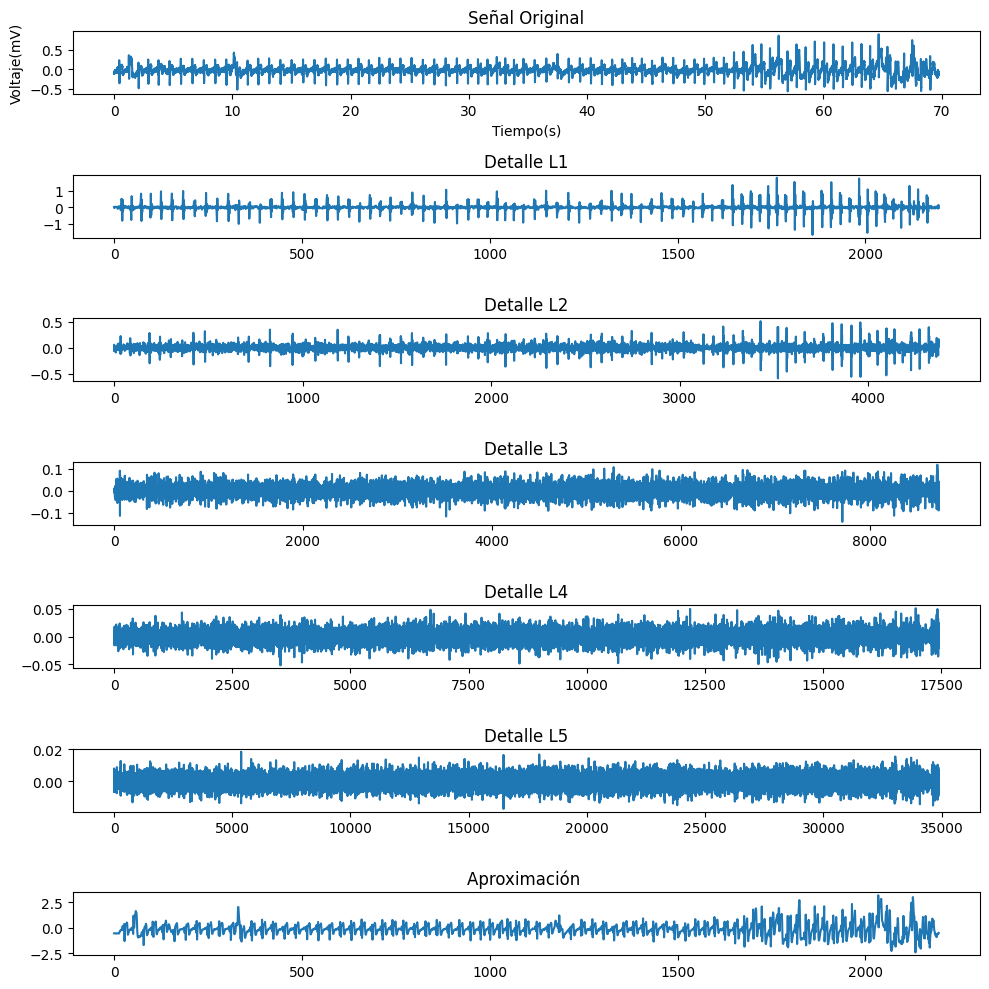

In [8]:
niveles_ecg = 5
coeficientes_ecg = pywt.wavedec(ecgsignal_semifilt, 'db9', level=niveles_ecg)

plt.figure(figsize=(10, 10))
plt.subplot(niveles_ecg + 2, 1, 1)
plt.plot(time,ecgsignal_semifilt)
plt.ylabel('Voltaje(mV)')
plt.xlabel('Tiempo(s)')
plt.title('Señal Original')

for i, detalle in enumerate(coeficientes_ecg[1:]):  # Empezar desde el segundo nivel
    plt.subplot(niveles_ecg + 2, 1, i + 2)
    plt.plot(detalle)
    plt.title(f'Detalle L{i+1}')

plt.subplot(niveles_ecg + 2, 1, niveles_ecg + 2)
plt.plot(coeficientes_ecg[0])
plt.title(f'Aproximación ')
plt.tight_layout()
plt.show()


In [13]:
#Aplicamos el filtro
umbral = 0.02

coeficientes_umbral_ecg = [pywt.threshold(c, umbral, mode='soft') for c in coeficientes_ecg]
senal_filtrada_ecg = pywt.waverec(coeficientes_umbral_ecg, 'db9')

bokeh_fig = bsnb.figure(x_axis_label="Tiempo(s)", y_axis_label="Amplitud(mV)")
bokeh_fig.line(time, senal_filtrada_ecg, legend_label="ECG")
bokeh_fig.title.text = "ECG Filtrada"
bsnb.show(bokeh_fig)

## Análisis en el dominio de la frecuencia

In [16]:
N = len(senal_filtrada_ecg)
yf = np.fft.fft(senal_filtrada_ecg)
xf = np.linspace(0.0, 1.0/(2.0*Ts_ecg), N//2)
bokeh_fig = bsnb.figure(x_axis_label="Frecuencia (Hz)", y_axis_label="Magnitud")
bokeh_fig.line(xf, 2.0/N * np.abs(yf[0:N//2]), legend_label="ECG")
bokeh_fig.title.text = "Espectro de frecuencias ECG filtrada"
bsnb.show(bokeh_fig)

## Extracción de características y almacenamiento en un archivo .csv

In [29]:
resultados = []
#Partimos la señal en segmentos de 3 segundos para registrar sus características
for i in range (0,60000, 3000):
  ecg_3s = senal_filtrada_ecg[i:i+3000]
  time = time[i:i+300]
  tachogram_data, tachogram_time = bsnb.tachogram(ecg_3s, Fs_ecg, signal=True, out_seconds=True)
  tachogram_data_NN, tachogram_time_NN = bsnb.remove_ectopy(tachogram_data, tachogram_time)

  # Maximum, Minimum and Average RR Intervaldata_NN)
  max_rr = max(tachogram_data_NN)
  min_rr = min(tachogram_data_NN)
  avg_rr = np.average(tachogram_data_NN)

  # Maximum, Minimum and Average Heart Rate
  max_hr = 1 / min_rr # Cycles per second
  max_bpm = max_hr * 60 # BPM

  min_hr = 1 / max_rr # Cycles per second
  min_bpm = min_hr * 60 # BPM

  # SDNN
  sdnn = np.std(tachogram_data_NN)

  time_param_dict = {"Max RR": max_rr,
                     "Min RR": min_rr,
                     "Average RR": avg_rr,
                     "Max BPM": max_bpm,
                     "Min BPM": min_bpm,
                     "SDNN": sdnn}
  resultados.append(time_param_dict)

#Almacenamos las características extraídas en un archivo CSV.
df = pd.DataFrame(resultados)
nombre_archivo = 'DataSet_ECG_G4.csv'
df.to_csv(nombre_archivo, index=True, sep=',')

print(f'Los resultados se han guardado en el archivo CSV: {nombre_archivo}')

Los resultados se han guardado en el archivo CSV: DataSet_ECG_G4.csv


In [30]:
#Descargamos el archivo.
from google.colab import files
files.download(nombre_archivo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>